# Partie 2: RNNs et description d'images

Fait par **Antoine Théberge** de l'Université de Sherbrooke, Canada.

Inspiré par la partie sur les auto-encodeurs et [un notebook similaire.](https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Show%2C%20Attend%20and%20Tell.ipynb).

Dans ce notebook, nous verrons comment construire un réseau récurrent avec `pytorch` et ce, dans le but de faire de la description d'images. Le réseau aura deux parties: un encodeur convolutionnel pour extraire des caractéristiques (*features*) de l'image.  Ces caractéristiques seront ensuite  données au décodeur, un LSTM, afin de produire des jetons de mots (*word tokens*) décrivant l'image.

Si vous exécutez ce notebook, il est *fortement* recommendé d'utiliser Google Colab. Si vous souhaitez tout de même entraîner le modèle sur votre ordinateur et utiliser les jeux de données, assurez vous d'avoir environs 12Gb de VRAM et 40GBb d'espace disque. 

Premièrement, un peu de poutine:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Change according to your own Google Drive config
!cp -r drive/MyDrive/IFT780/TP3/* .

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture packages_install

# Make sure the repo's package and its dependencies are installed
!pip install -e .

In [ ]:
%%capture project_path_setup

import sys

if '../' in sys.path:
    print(sys.path)
else:
    sys.path.append('../')
    print(sys.path)

Téléchargeons les données. Ceci devrait prendre de 10 à 20 minutes sur Google Colab.

In [ ]:
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!unzip -q 'train2017.zip'
!rm 'train2017.zip'

!wget -nc http://images.cocodataset.org/zips/val2017.zip
!unzip -q 'val2017.zip'
!rm 'val2017.zip'

!wget -nc http://images.cocodataset.org/zips/test2017.zip
!unzip -q 'test2017.zip'
!rm 'test2017.zip'

!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q 'annotations_trainval2017.zip'

!wget -nc http://images.cocodataset.org/annotations/image_info_test2017.zip
!unzip -q 'image_info_test2017.zip'

!wget -nc http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
!unzip -q 'caption_datasets.zip'

--2023-03-20 22:46:48--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.93.220, 52.217.235.113, 3.5.27.112, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.93.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  9.24MB/s    in 25m 38s 

2023-03-20 23:12:26 (12.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-03-20 23:15:20--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.169.33, 52.216.88.83, 52.217.85.148, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.169.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777

### Regardons nos données

Dans ce notebook, nous travaillerons sur le jeu de données [COCO](https://cocodataset.org/). COCO contient quelques centaines de millier d'images avec pour chacune une description textuelle (*image captionning*), mais aussi la détection d'objets et la segmentation.

Concentrons nous sur la description d'images, regardons quelques images du jeu de données.

In [ ]:
def display_images_with_captions(
    images, captions, decode_ids=False, vocab=None, token_formatter=None
):
    num_samples = len(images)
    plt.axis('off')

    fig, axes = plt.subplots(figsize=(10, len(images) * 0.5 * 2), nrows=num_samples, ncols=2)

    def _display_sample(ax_idx, sample, sample_label) -> None:
        ax = plt.subplot(num_samples, 2, ax_idx)
        ax.imshow(sample.detach().cpu().numpy().transpose((1, 2, 0)))
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, ax_idx + 1)
        if decode_ids and vocab:
            text = [vocab.lookup_token(i) for i in sample_label]
            ax.text(0.25, 0.5, token_formatter(text), wrap=True)
        else:
            ax.text(0.25, 0.5, sample_label[0], wrap=True)
        ax.axis('off')

    # Display the sample for the current column from each data source
    for src_idx, (img, cap) in enumerate(zip(images, captions)):
        _display_sample((src_idx * 2) + 1, img, cap)

    fig.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=1.58s)
creating index...
index created!


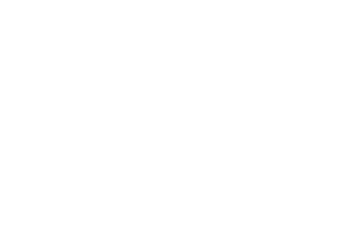

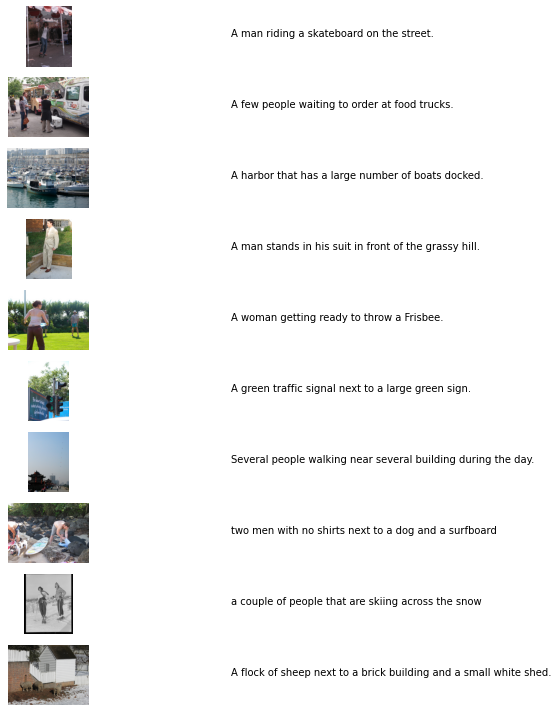

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CocoCaptions
from torchvision.transforms import transforms

# COCO has variable image sizes, so we will resize them to 256x256.
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the data
coco2017 = CocoCaptions(root="./train2017", annFile="./annotations/captions_train2017.json", transform=transform)

# Check data by displaying random images
samples_indices = np.random.randint(len(coco2017), size=10)
coco_img_list = [coco2017[sample_idx][0] for sample_idx in samples_indices]
coco_cap_list = [coco2017[sample_idx][1] for sample_idx in samples_indices]
display_images_with_captions(coco_img_list, coco_cap_list)

Le jeu de données COCO contient plusieurs descriptions par images, mais nous n'en affichons qu'une seule. Vous pouvez ré-exécuter la cellule afin de visualier différentes paires d'images/descriptions.

En regardant directement les données, on peut voir la forme que prennent celles-ci.

Image size =  (3, 480, 640)
Image size =  (480, 640, 3)
The image label is  ['Closeup of bins of food that include broccoli and bread.', 'A meal is presented in brightly colored plastic trays.', 'there are containers filled with different kinds of foods', 'Colorful dishes holding meat, vegetables, fruit, and bread.', 'A bunch of trays that have different food.']


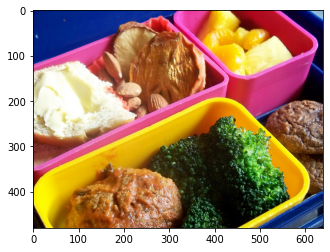

In [ ]:
import matplotlib.pyplot as plt

# Get the first training image and its class label
sample_image = coco2017[0][0] # sample_image is a "PyTorch tensor"
sample_labels = coco2017[0][1] 

# Convert the Tensor into a numpy array
sample_image_np = sample_image.numpy()  
print("Image size = ", sample_image_np.shape)

# Call "transpose" to go from C*W*H to H*W*C
sample_image_np = sample_image_np.transpose((1,2,0))
print("Image size = ", sample_image_np.shape)

# Plot
plt.imshow(sample_image_np)
print("The image label is ", sample_labels)

### Transformations et jetonisations du text

Ici, nous appliquerons quelques transformations au jeu de données afin de le rendre utilisable par notre modèle. Premièrement, nous allons "jetoniser" (*tokenize*) le text.

Plusieurs options s'offrent à nous pour la granularité des jetons. Voulons-nous un jeton par caractère ? Un jeton par mot ? Quelque chose entre les deux ? Pour ce notebook, nous prendrons un ensemble de jetons déjà précalculés pour nous, correspondant à chaque mot dans l'ensemble des descriptions. Premièrement, définissons quelques classes qui nous serons utiles.

In [ ]:
from torch.nn import Module

# Transform to select only the first n captions out of all                                                                                                                         
class NCaptionTransform(Module):
    def __init__(self, n):
        self.n = n
        
    def __call__(self, target):
        if self.n == 1:
          return target[0]
        else:
          return target[:self.n]
    
# Define a tokenizer transform to automatically transform string captions into tokens
# (not sure why this is not built in torchtext)
class TokenizerTransform(Module):
    def __init__(self, tokenizer):
        super(TokenizerTransform).__init__()
        self.tokenizer = tokenizer
        
    def __call__(self, captions):
        return [self.tokenizer(c) for c in captions]

# Last, we will need a way to obtain sentences from a list of tokens when we will evaluate the model ourselves
class TokenFormatter(object):                                                                                                                                                                                
    def __init__(self, start_token, end_token, pad_token):
        self.bos = start_token
        self.eos = end_token
        self.pad = pad_token
        self.filter = [self.bos, self.eos, self.pad]
    def __call__(self, tokens):  
        tokens = list(filter(lambda t: t not in self.filter, tokens))
        return ' '.join(tokens)  

Ensuite, définissons des jetons spéciaux et batissons notre vocabulaire, soit l'ensemble de tous les jetons que notre modèle pourra prédire.

## Question:
* À quoi servent les jetons spéciaux \[START\], \[END\], \[PAD\], \[UNK\] ? Donnez une réponse par jeton.

\[START\] est utilisé pour indiquer le début d'une séquence de mots ou de caractères.

\[END\] est utilisé pour indiquer la fin d'une séquence de mots ou de caractères.

\[PAD\] est utilisé pour faire du pading, c'est-à-dire remplir des séquences plus courtes avec des valeurs vides afin de les rendre de la même longueur que les séquences plus longues.

\[UNK\] est utilisé pour représenter des mots ou des caractères inconnus ou rares qui ne sont pas dans le vocabulaire d'apprentissage du modèle.

In [ ]:
import string
import json

import torch
import torchtext.transforms as T

from torchtext.data import get_tokenizer
from torchtext.vocab import vocab, build_vocab_from_iterator    

# Captions will be truncated or padded to 20 tokens.
max_seq_len = 20

# Images will be resized to 256x256
data_shape = (256, 256)
    
# We define special tokens
start_token = "[START]"
end_token = "[END]"
pad_token = "[PAD]"
unk_token = "[UNK]"

with open('./dataset_coco.json', 'r') as f:
    data = json.load(f)
    # We build a vocabulary from karpathy's tokens + punctuation and whitespace.
    vocab = build_vocab_from_iterator(
        (s["tokens"] for i in data["images"] for s in i["sentences"]),
        specials=[start_token, end_token, pad_token, unk_token] + list(string.whitespace)+ list(string.punctuation), 
        special_first=True)

unknown_token = vocab(["[UNK]"])[0]
vocab.set_default_index(unknown_token)

# Keep the ids of special tokens in the vocabulary
# These will be useful later.
BOS_IDX, EOS_IDX, PAD_IDX, UNK_IDK = vocab.lookup_indices([start_token, end_token, pad_token, unk_token])

eng_tokenizer = get_tokenizer("basic_english")

# Define a series of transformations to apply on the targets (the captions)
text_transform = T.Sequential(
    TokenizerTransform(eng_tokenizer), # transform the textual captions into a series of tokens.
    T.VocabTransform(vocab), # transform the tokens into ids.
    T.AddToken(token=BOS_IDX, begin=True), # automatically prepend the the start token.
    T.AddToken(token=EOS_IDX, begin=False), # automatically append the the end token.
    T.Truncate(max_seq_len), # truncate the sequence to the maximum length. .
    NCaptionTransform(1), # only extract one caption amongst all available .
    T.ToTensor(PAD_IDX, dtype=torch.int64), # transform the targets into a tensor.
    T.PadTransform(max_seq_len, PAD_IDX)) # pad the captions, if they weren't truncated, to the maximum length.

# Transformations on the images.
transform = transforms.Compose([
    transforms.ToTensor(), # Cast them as tensors 
    transforms.Resize(data_shape), # Resize the tensors to 256x256
])

# Instanciate the token formatter. This will allow us to write actual decoded captions from tokens.
token_formatter = TokenFormatter(start_token, end_token, pad_token)

Maintenant que nous avons géré la jetonisation et les transformations, nous pouvons instancier nos jeux de données. 

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Tokenized and ided caption is tensor([  0,  42,  61, 205,  46,  45, 502, 140,  55,  45,  63,  23,   1,   2,
          2,   2,   2,   2,   2,   2])


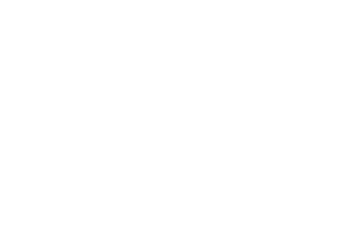

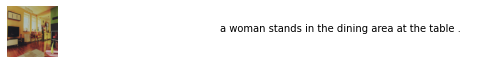

In [ ]:
# Train, val and test sets are already split for us. Note that the test set has no transformations applied to the 
# captions, as ground truth captions are not available on the test set.
coco2017_train = CocoCaptions(root="./train2017", annFile="./annotations/captions_train2017.json", transform=transform, target_transform=text_transform)
coco2017_val = CocoCaptions(root="./val2017", annFile="./annotations/captions_val2017.json", transform=transform, target_transform=text_transform)
coco2017_test = CocoCaptions(root="./test2017", annFile="./annotations/image_info_test2017.json", transform=transform)

# Get the first training image and its class label
sample_image = coco2017_val[0][0] # sample_image is a "PyTorch tensor"
sample_labels = coco2017_val[0][1] # sample label is a list of captions

print("Tokenized and ided caption is", sample_labels)

display_images_with_captions(sample_image[None, ...], sample_labels[None, ...], decode_ids=True, vocab=vocab, token_formatter=token_formatter)

### Développons notre RNN !  

Nous sommes maintenant rendu à l'étape de la conception du RNN. Premièrement, définissons notre encodeur, un Resnet50 pré-entraîné. 

In [ ]:
from torch import nn
from torchvision.models import resnet50

class CNNEncoder(nn.Module):
    """ Encoder. Uses a pretrained resetnet50 model to project images to features.
    """
    def __init__(self):
        super(CNNEncoder, self).__init__()
        
        # Base ResNet
        # The original impl. uses a VGGNet which outputs 14x14x512 feature maps
        # We will add a pooling layer to output 14x14x2048 instead of 8x8x2048
        base = resnet50(pretrained=True) 
        for param in base.parameters():
            param.requires_grad = False
        # remove last layers (avg pool and fc) of ResNet usually used for classification
        pooling = nn.AdaptiveAvgPool2d((14, 14))
        modules = list(base.children())[:-2] + [pooling]
        self.model = nn.Sequential(*modules)
    
    def forward(self, images):
        """
        Forward propagation.
        
        Args:
        images: images, a tensor of size (batch_size, 3, 256, 256)
        
        Returns:
        out: features, tensor of size (batch_size, 2048, 14, 14)
        """
        out = self.model(images) # (batch_size, 2048, 14, 14)
        return out

# Question:

* Pourquoi utiliser un modèle pré-entraîné ? Pourquoi ne pas entraîner aussi l'encodeur ?

On utilise un modèle pré-entrainé car il permet de gagner du temps (on a moins à l'entrainer). Aussi, ces modèles sont généralement entraînés sur de grandes quantités de données permettant de mieux généraliser.

* Expliquez dans vos propres mots quelle est la représentation de l'image en sortie de l'encodeur. Considérez la taille du tenseur, ce qu'il représente, et l'architecture Resnet50.

Le tenseur de sortie représente une version compressée de l'image d'entrée, les informations pertinentes pour la tâche de reconnaissance d'images y ont été extraites et encodées sous forme de caractéristiques. Ainsi, les dimensions du tenseur reflètent les différentes caractéristiques extraites de l'image.

Maintenant le décodeur. Celui-ci est un LSTM qui recevra en entrée le dernier jeton prédit, l'image en entrée et ses états cachés. 

In [ ]:
from torch import nn
    
class RNNDecoder(nn.Module):
    
    def __init__(self, embed_size, decoder_size, vocab_size, device):
        """ Decoder. Uses an RNN (LSTM) to predict captions. Uses its hidden features (h, c), the last
        (embedded) token and features of the input image to predict the next token.
        

        """
        super(RNNDecoder, self).__init__()
        self.encoder_size = 2048 # set by ResNet. Could do a 1x1 conv to change it
        self.embed_size = embed_size
        self.decoder_size = decoder_size
        self.vocab_size = vocab_size
        self.device = device

        self.word_embedding = nn.Embedding(vocab_size, embed_size, padding_idx=PAD_IDX) # embedding layer        
        self.features_pool = nn.AdaptiveAvgPool2d((1, 1)) # To go from 14x14x2048 to 1x1x2048
        
        self.init_h = nn.Linear(self.encoder_size, decoder_size)   # To initialize h. Could also be set to 0 
        self.init_c = nn.Linear(self.encoder_size, decoder_size)    # To initialize c. Could also be set to 0.
        self.rnn = nn.LSTMCell(self.encoder_size + embed_size, decoder_size, bias=True) # Actual decoder
        self.fc = nn.Linear(decoder_size, vocab_size)        # To map from RNN features to class scores
        self.dropout = nn.Dropout(p=0.5) # To avoid overfitting
    
    def init_hidden_state(self, features):
        """
        Creates the initial hidden and cell states for the decoder's LSTM based on the encoded images.
        
        """
        h = self.init_h(features)
        c = self.init_c(features)
        return h, c
    
    def forward(self, features, captions):
        """
        Decoding forward prop.
        
        
        """
        # Batch size, max_seq_len
        B, T  = captions.size()

        # Average out feature "pixels" into one
        # Could also use a single conv. or flatten the features then feed to a lin. layer
        features = self.features_pool(features)
        # Batch size, 2048, 1, 1
        B, C, H, W = features.size()
        # Batch size, self.encoder_size
        features = features.reshape(B, H * W, C).squeeze(1)

        # Word embedding based on ground-truth captions
        embeddings = self.word_embedding(captions)
        
        # Placeholder tensor for scores of each class at each timestep
        # Size of batch size, caption max length, vocab size
        scores = torch.zeros((B, max_seq_len, self.vocab_size)).to(self.device)
        
        # Init h,c based on encoded features
        h, c = self.init_hidden_state(features)
        
        # Time to actually decode
        for t in range(T):

            # Decode based on the current (embedded) token, the image features and the hidden states 
            h, c = self.rnn(
                torch.cat([embeddings[:, t, :], features], dim=-1), (h, c))

            # Predict based on new hidden features
            scores_t = self.fc(self.dropout(h))

            # Save the predictions at time t
            scores[:, t, :] = scores_t
    
        return scores
    
    def predict(self, features, T):
        """
        Inference propagation.
        
        Args:
        features: tensor of sizeension (batch_size, enc_image_size, enc_image_size, encoder_size)
        max_seq_len: maximum caption length.
        
        Returns:
        captions: padded predicted captions.
        """
        
        # Explicitely don't compute gradients
        with torch.no_grad():
            
            # Average out feature "pixels" into one
            # Could also use a single conv. or flatten the features then feed to a lin. layer
            features = self.features_pool(features)
            # Batch size, 2048, 1, 1
            B, C, H, W = features.size()
            # Batch size, self.encoder_size
            features = features.reshape(B, H * W, C).squeeze(1)
            
            # Placeholder tensor for predicted token idx
            # Size of batch size, caption max length, vocab size
            # pad_idx is passed "globally" which is kind of dirty.
            captions = torch.full((B, T), PAD_IDX, dtype=torch.int64).to(self.device)
            # Set [START] at T=0
            captions[:, 0] = BOS_IDX
        
            # Init h,c based on encoded features
            h, c = self.init_hidden_state(features)

            # Keep track of which caption is complete.
            stopped = np.asarray([False] * B)
            
            for t in range(T-1):
                # Embed at each timestep since embedding changes
                embeddings = self.word_embedding(captions)

                # Decode based on the current (embedded) token, the image features and the hidden states 
                h, c = self.rnn(
                    torch.cat([embeddings[:, t, :], features], dim=-1), (h, c))

                # get the next word prediction
                scores = self.fc(self.dropout(h))                
                pred_t = torch.argmax(scores, dim=-1)
                                
                # Only keep captions which are not over
                captions[~stopped, t+1] = pred_t[~stopped]

                # See if the caption is complete i.e. [END] token has been predicted
                stopped = np.logical_or(stopped, pred_t.cpu().numpy() == EOS_IDX)
                
                # No point in predicting if everything has stopped.
                if np.all(stopped):
                    break

            return captions.cpu().numpy()

## Questions:

* Quel est l'utilité de la "embedding layer" ?

L'utilité de la couche d'embedding est de transformer des données de texte brutes en vecteurs numériques et qui capturent la proximité sémantique et syntaxique entre les mots.

* Que représente la sortie du modèle dans la fonction `forward` ? Et dans la fonction `predict` ?

La sortie de la fonction `forward`retourne pour chaque position de la description de l’image, les prédictions des probabilités pour chaque mot du vocabulaire. La sortie de `predict` nous fournit la description de l’image inférée.

* Quelles sont les différences entre l'entrée du LSTM dans la fonction `forward` et la fonction `predict` ? Quels sont les avantages d'avoir ces différences ?

La fonction `foward` permet d’entrainer le modèle en lui donnant des images ainsi que les descriptions associées à chacune d’elle, donc ici, la fonction retourne le score de l’entrainement.
La fonction `predict` elle, est utilisée lors de l'inférence, que le modèle génère les descriptions des images que nous lui passons, et nous les retourne.

Définissons la propagation avant, qui calculera aussi la fonction de perte.

In [ ]:
import torch
import torch.nn.functional as F

from torch.nn.utils.rnn import pack_padded_sequence

def collate_fn(data):
    # Not sure why there is no built-in way of doing this in torch
    images, captions = map(torch.stack, zip(*data))
    return images, captions

def get_lengths_of_padded_captions(captions, pad_idx):
    lengths = np.zeros(captions.shape[0])
    for i, c in enumerate(captions):
        for j, char in enumerate(c):
            if char == pad_idx:
                break
            lengths[i] = j
    return lengths

def forward_pass(encoder, decoder, loss_fn, images, captions, lengths):
    """Encoder-Decoder forward pass.

    Args:
        encoder_decoder: neural net that predicts a caption given an image
        images: batch of N COCO images
        captions: batch of N target captions for the images

    Returns:
        loss: crossentropy loss
        predictions: batch of N predicted captions
    """

    # Project the image to features
    features = encoder(images)
    # Feed them to the decoder to obtain captions
    predictions = decoder(features, captions)
    # We did not decode the [START] token
    targets = captions[:, 1:]        
    # "Pack" predictions and targets by removing all padding tokens and reshaping the result into a "flat" tensor
    packed_predictions, packed_captions = (pack_padded_sequence(predictions, lengths, batch_first=True, enforce_sorted=False), 
                                           pack_padded_sequence(targets, lengths, batch_first=True, enforce_sorted=False))
    loss = loss_fn(packed_predictions.data, packed_captions.data).mean()  # Compute the reconstruction loss
    
    return loss, predictions

## Boucles d'entraînement

Avant d'entraîner notre modèle, nous devons définir des boucles d'entraînement. Premièrement, une boucle de sur-apprentissage permettant de valider que notre modèle fonctionne et peut sur-apprendre sur un petit ensemble de données. Puis, la boucle d'entraînement. Celle-ci itérera sur toutes les données en entraînement afin de calculer et rétro-propager la fonction de perte, puis calculera la fonction de perte sur les données en validation.

In [ ]:
import numpy as np
from tqdm.auto import tqdm

def overfit(encoder, decoder, forward_pass, optimizer, loss_fn, train_dataloader, device):
    """ Overfitting method to ensure everything is properly implemented.
    """
    
    # Helper to visualize the training progression
    fit_pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    pbar_metrics = {"train_loss": None}
    
    images, captions = next(iter(train_dataloader)) # Only sample the first batch of the dataloader
    train_losses = []
    # Train for n epochs on the same data
    for epoch in fit_pbar:
        optimizer.zero_grad()   # Make sure gradients are reset
        # Get the length of each caption without padding to compute the loss
        # We don't want to penalize the model for not predicting the padding token
        lengths = get_lengths_of_padded_captions(captions, PAD_IDX)
        train_loss, _ = forward_pass(encoder, decoder, loss_fn, images.to(device), captions.to(device), lengths)    # Forward pass
        train_loss.backward()   # Backward pass
        optimizer.step()    # Update parameters w.r.t. optimizer and gradients
        train_losses.append(train_loss.item())
        pbar_metrics["train_loss"] = np.mean(train_losses)
        fit_pbar.set_postfix(pbar_metrics)

        
def train(encoder, decoder, forward_pass, optimizer, loss_fn, train_dataloader, val_dataloader, device):
    """ Training loop.
    """
    
    # Helper to visualize the training progression
    fit_pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    pbar_metrics = {"train_loss": None, "val_loss": None}
    
    # For each epoch
    for i, epoch in enumerate(fit_pbar):
        
        torch.save(decoder.state_dict(), '{}_{}.pth'.format(decoder.__class__.__name__, i))
        
        decoder.train()
        train_losses = []
        val_losses = []
        # Train over all the training data
        for images, captions in train_dataloader:
            optimizer.zero_grad()   # Make sure gradients are reset
            # Get the length of each caption without padding to compute the loss
            # We don't want to penalize the model for not predicting the padding token
            lengths = get_lengths_of_padded_captions(captions, PAD_IDX)
            # Compute the forward pass and the corresponding loss
            train_loss, _ = forward_pass(
                encoder, decoder, loss_fn, 
                images.to(device), captions.to(device), lengths)    # Forward pass
            train_loss.backward()   # Backpropagate the loss to compute gradients
            optimizer.step()    # Update parameters w.r.t. optimizer and gradients
            
            train_losses.append(train_loss.item())
            pbar_metrics["train_loss"] = np.mean(train_losses)
            fit_pbar.set_postfix(pbar_metrics)
        
        decoder.eval()
        # At the end of the epoch, check performance against the validation data
        for images, captions in val_dataloader:
            # Don't compute gradients during validation
            with torch.no_grad():
                # Get the length of each caption without padding to compute the loss
                # We don't want to penalize the model for not predicting the padding token
                lengths = get_lengths_of_padded_captions(captions, PAD_IDX)
                # Compute the forward pass and the corresponding loss
                val_loss, _ = forward_pass(
                    encoder, decoder, loss_fn, 
                    images.to(device), captions.to(device), lengths)            
                val_losses.append(val_loss.item())
                pbar_metrics["val_loss"] = np.mean(val_losses)
                
        print(pbar_metrics)
        
        torch.save(decoder.state_dict(), '{}_{}.pth'.format(decoder.__class__.__name__, i))

Avant d'entraîner le modèle, essayons de sur-apprendre sur un petit ensemble de données.

In [ ]:
import os
import torch
import torch.optim as optim

from torch.utils.data import DataLoader

# Define some overfitting hyperparameters
epochs = 100
batch_size = 10 # Only train on 10 images
embedding_size = 512
decoder_size = 512
vocab_size = len(vocab)
lr = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# Instanciate the encoder
encoder = CNNEncoder()
# Instanciate the decoder
decoder = RNNDecoder(embedding_size, decoder_size, vocab_size, device)
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
# Define the optimizer. Note that only the decoder's parameters will be optimized
optimizer = optim.Adam(decoder.parameters(), lr=lr)
# Send the models to the GPU (if available)
encoder, decoder = encoder.to(device), decoder.to(device)

# Define the dataloader. Only its first batch will be used.
overfit_dataloader = DataLoader(
    coco2017_train, batch_size=batch_size, shuffle=False, num_workers=8, 
    collate_fn=collate_fn, pin_memory=device=="cuda")

# Start the overfitting process
overfit(encoder, decoder, forward_pass, optimizer, loss_fn, overfit_dataloader, device)

cuda


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

## Question

* Pourquoi utilser l'entropie-croisée comme fonction de perte ? Pourquoi pas une fonction de perte `l2`, par exemple ?

En utilisant l'entropie-croisée comme fonction de perte, le modèle est entraîné à minimiser la divergence entre la distribution de probabilité prédite et la distribution de probabilité cible. Cela permet d'obtenir des prédictions plus précises.

En revanche, si on utilise une fonction de perte `l2` pour ce problème de classification, comme la fonction de perte `l2` ne prend pas en compte la structure probabiliste de la sortie du modèle et peut donc pénaliser de manière équivalente les prédictions fausses et les prédictions très proches de la vérité, cela peut conduire à des prédictions moins précises

Voyons voir le résultat sur les mêmes données. Définissons nous d'abord une fonction permettant de prédire simplement, sans calculer la fonction de perte.

In [ ]:
def predict_pass(encoder, decoder, images, max_seq_len):
    """Encoder-Decoder prediction pass.

    Args:
        encoder: neural net that output features given an image
        decoder: 
        images: batch of N COCO images
        captions: batch of N target captions for the images

    Returns:
        predictions: predicted captions
        lengths: batch of N integers representing the length of each captions
    """
    # Project the image to features
    features = encoder(images.to(device))
    # Feed them to the decoder to obtain captions
    predictions = decoder.predict(features, max_seq_len)
    return predictions

Puis, visualisons les résultats.

Predicted captions


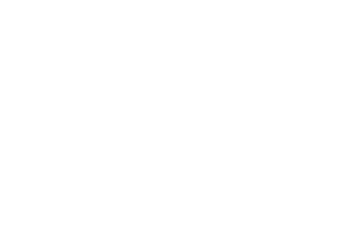

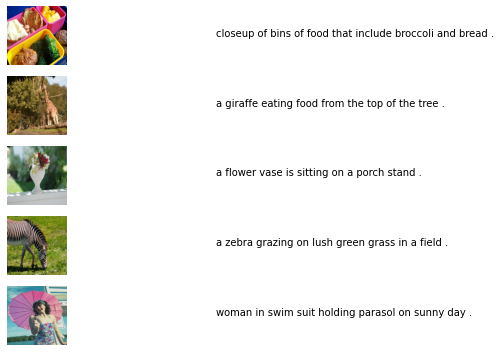

Ground truth captions


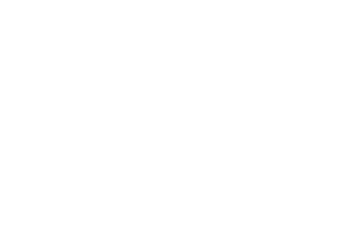

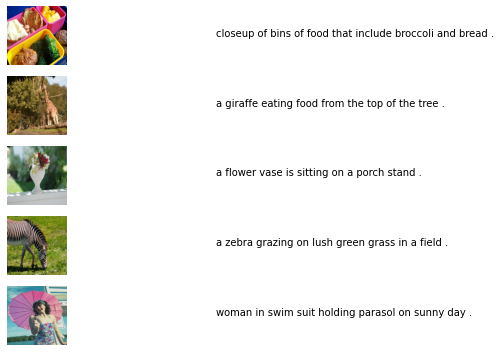

In [ ]:
# Declare a new dataloader to visualize the overfitting results
overfit_test_dataloader = DataLoader(
    coco2017_train, batch_size=5, shuffle=False, num_workers=1, 
    collate_fn=collate_fn, pin_memory=device=="cuda")

# Sample the first batch, same as in the overfitting procedure
images, captions = next(iter(overfit_test_dataloader))

# Predict captions for the images
predictions = predict_pass(encoder, decoder, images, max_seq_len)

print("Predicted captions")
display_images_with_captions(images, predictions, decode_ids=True, vocab=vocab, token_formatter=token_formatter)

print("Ground truth captions")
display_images_with_captions(images, captions, decode_ids=True, vocab=vocab, token_formatter=token_formatter)

Les résultats devraient être convainquants. C'est maintenant le temps d'entraîner ! De par la taille du jeu de données, seulement quelques itérations sur le jeu d'entraînement devraient suffir. Ça prend environs 90 minutes entraîner le modèle pendant 10 epochs sur ma carte graphique 1080ti. Les temps sont variables sur Google Collab et peuvent être supérieurs. Si vous souhaitez entraîner sur votre propre ordinateur, vous pouvez réduire ou augmenter la taille de la *batch*, mais vous ne devriez pas avoir besoin de changer autre chose.

**Si vous ne souhaitez pas entraîner**, vous pouvez charger directement les paramètres du modèle à la cellule suivante.

In [ ]:
import os
import torch
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define some training hyperparameters
epochs = 10
batch_size = 128
embedding_size = 512
decoder_size = 512
vocab_size = len(vocab)
lr = 4e-4

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

# Instanciate the encoder
encoder = CNNEncoder()
# Instanciate the decoder
decoder = RNNDecoder(embedding_size, decoder_size, vocab_size, device)
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
# Define the optimizer. Note that only the decoder's parameters will be optimized
optimizer = optim.Adam(decoder.parameters(), lr=lr)
# Send the models to the GPU (if available)
encoder, decoder = encoder.to(device), decoder.to(device)

# Training and validation dataloaders
train_dataloader = DataLoader(
    coco2017_train, batch_size=batch_size, shuffle=False, num_workers=10, 
    collate_fn=collate_fn, pin_memory=device=="cuda")
val_dataloader = DataLoader(
    coco2017_val, batch_size=batch_size, shuffle=False, num_workers=10, 
    collate_fn=collate_fn, pin_memory=device=="cuda")

train(encoder, decoder, forward_pass, optimizer, loss_fn, train_dataloader, val_dataloader, device)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

KeyboardInterrupt: ignored

Si vous avez entraîné le modèle, vous pouvez ignorer la cellule suivante.

In [ ]:
embedding_size = 512
decoder_size = 512
vocab_size = len(vocab)

# Instanciate the encoder
encoder = CNNEncoder()
# Instanciate the decoder
decoder = RNNDecoder(embedding_size, decoder_size, vocab_size, device)
decoder.load_state_dict(torch.load('weights/RNNDecoder.pth'))
# Send the models to the GPU (if available)
encoder, decoder = encoder.to(device), decoder.to(device)

FileNotFoundError: ignored

Une fois l'entraînement terminé, visualisons les résultats sur le jeu d'entraînement. Puisque nous n'avons pas les descriptions des images dans le jeu de test, vous devrez juger de la qualité de la description par vous-même.

In [ ]:
test_dataloader = DataLoader(
    coco2017_test, batch_size=5, shuffle=True, num_workers=1)

images, _ = next(iter(test_dataloader))

predictions = predict_pass(encoder, decoder, images, max_seq_len)

display_images_with_captions(images, predictions, decode_ids=True, vocab=vocab, token_formatter=token_formatter)

Les résultats devraient être généralement bien, mais certaines erreurs devraient s'introduire dans les résultats. Vous pouvez exécuter la cellule précédente plusieurs fois pour obtenir des résultats différents.

## Questions:

* Les descriptions générées à la cellule précédente devraient parfois manquer de précision, inclure des éléments de trop ou en omettre ("*a group of cows standing ...*" versus "*a cow standing ...*", par exemple). Pourquoi croyez-vous que cela se produit ? Prenez en compte l'architecture des deux modèles et les tenseurs échangés entre ceux-ci. Indice: ce n'est pas dû à l'entraînement ou parce que le modèle n'a pas convergé ou par manque de données. Si vous êtes courageux.euses, vous pouvez entraîner le modèle plus longtemps pour vous en convaincre.

Le modèle de langage est conditionné par rapport à la représentation de l'image par les informations dans l’espace latent, mais il n'a pas accès à l'image elle-même. Par conséquent, le modèle peut ne pas être en mesure de capturer toutes les nuances de l'image et peut manquer des détails importants.

* Pour cette implémentation, nous avons utilisé un ensemble de jetons correspondant grosso modo à chaque mot dans l'ensemble de toutes les descriptions. Combien de jetons font partie du vocabulaire du modèle ?

Il y a autant de jetons que de mots dans le vocabulaire soit 27964.

* Quel aurait été l'impact sur le modèle, sur son nombre de paramètres et sur la difficulté du problème si nous avions choisi d'avoir plutôt un jeton par caractère ?

Le problème serait plus difficile. Avoir un jeton par caractère aurait augmenté considérablement la taille et la complexité du modèle, et aurait nécessité plus de ressources pour l'entraînement et l'inférence. Donc nous aurions d’eu ajouter beaucoup plus de paramètre pour données au modèle la capacité à recréer des mots valides en plus.

In [ ]:
len(vocab)

27964